# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.790970,False,-0.155237
1,-1.798436,False,-0.867401
2,0.332897,True,6.516229
3,-2.593850,False,-2.853900
4,-0.370484,False,-0.488782
...,...,...,...
995,-1.299448,False,-2.845319
996,-0.791570,True,5.228880
997,-1.040983,True,2.617555
998,0.157243,True,3.257913


<AxesSubplot:xlabel='v0'>

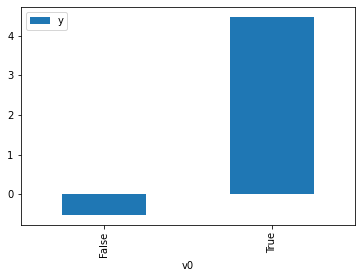

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

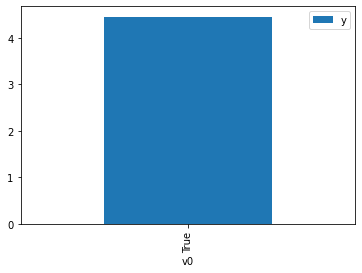

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.204484,False,-1.724063,0.878640,1.138122
1,-1.184127,False,0.776954,0.741208,1.349149
2,-0.672982,False,-0.574813,0.642837,1.555605
3,-2.825907,False,-2.868167,0.927197,1.078520
4,-0.937298,False,-0.415856,0.695916,1.436956
...,...,...,...,...,...
995,-1.416970,False,-1.783701,0.779693,1.282556
996,-0.670404,False,-2.347864,0.642299,1.556908
997,-2.649378,False,-0.896442,0.915596,1.092184
998,-2.460834,False,-1.858701,0.901376,1.109415


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.461383,True,2.888078,0.098580,10.144054
1,-1.477651,True,1.686898,0.210980,4.739788
2,-0.943287,True,4.155861,0.302934,3.301053
3,0.756196,True,4.784443,0.670672,1.491042
4,-3.405843,True,3.210876,0.044299,22.573941
...,...,...,...,...,...
995,0.486792,True,4.301010,0.614525,1.627272
996,0.112802,True,4.676018,0.531575,1.881201
997,-0.618640,True,5.174668,0.368581,2.713107
998,-0.948462,True,4.302587,0.301941,3.311901


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                              4486.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:46:41   Log-Likelihood:                         -1450.5
No. Observations:                1000   AIC:                                      2905.
Df Residuals:                     998   BIC:                                      2915.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8031      0.026     30.394      0.000       0.751       0.855
x2             5.0402      0.054     92.597      0.000       4.933       5.147
==============================================================================
Omnibus:                        0.541   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.431
Skew:                           0.035   Prob(JB):                        0.806
Kurtosis:                       3.073   Cond. No.                         2.08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""